Предметом исследования являются данные о пассажирах Титаника.
Цель данной работы: определить параметры которые в большей степени могут повлиять на выживаемость пассажиров.

### Context

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
pd.plotting.register_matplotlib_converters()
%matplotlib inline


Загрузим и посмотрим, что получили:

In [230]:
data = pd.read_csv("./data/train.csv", parse_dates=True)
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
5,5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,S
6,6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,S
7,7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,S
8,8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S
9,9,0,2,"Greigo, Rudy",male,66.00,0,0,6981,9.14,D2969,C


In [231]:
data.shape


(100000, 12)

Я думал на Титанике было тысячи 3 человек, а не 100 тыс.

### Data quality assessment

Посмотрим есть ли дубликаты по 'Survived', 'Pclass','Name','Sex','Age','SibSp','Parch','Ticket'

In [232]:
data[data[['Survived', 'Pclass','Name','Sex','Age','SibSp','Parch','Ticket']].duplicated()].groupby('Name').size()


Series([], dtype: int64)

Пока дубликатов нет. Но если убрать Ticket и далее, то они начинают появляться

In [233]:
df = data[['Name','Sex','Age']]
df[df.duplicated()].shape[0]

292

292 - будем считать что это тезки в кубе, и не будем от них избавляться.

Посмотрим на отсутствующие данные. В предоставленных данных часть отсутствующей информации была отмечена символом NaN. Но возможно среди символьных есть пропуски, которые не были отмечены NaN.

In [234]:
data[['Name', 'Sex', 'Ticket', 'Cabin']].apply(lambda x: x == '').sum()

Name      0
Sex       0
Ticket    0
Cabin     0
dtype: int64

Так, пропусков нет, можно посмотреть сколько всего имеем пропущенных данных. Для графического представления воспользуемся heatmap

<AxesSubplot:>

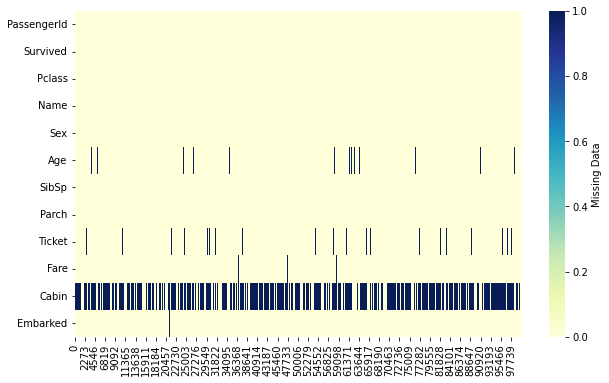

In [235]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [236]:
data.apply(lambda x: pd.isna(x)).sum()*100/data.shape[0]

PassengerId     0.000
Survived        0.000
Pclass          0.000
Name            0.000
Sex             0.000
Age             3.292
SibSp           0.000
Parch           0.000
Ticket          4.623
Fare            0.134
Cabin          67.866
Embarked        0.250
dtype: float64

Таким образом пропущенно около 4% данных в переменной Age, 5% в переменной Ticket и почти 68% в Cabin. И если с возрастом пассажиров и стоимостью билета можно провести обоснованное замещение пропущенных значений средним по классу, в связи с небольшой их долей, то с каютами такое не получится сделать, т.к. пропущенных значений существенно больше нежели заполненных. Пропущенные значения в признаке Embarked заменим на наиболее часто встречающееся место посадки.


In [237]:
data['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

Наиболее часто встречающееся место посадки - 'S'.

Возраст возьмем не средний по набору, а средний по каждому классу каюты, так как скорее всего в более дорогом классе ехали более состоятельные люди, а в более дешевом молодые - которые хотели эмигрировать в Америку и соответственно имевшие меньше денежных средств.
Еслибы в поле Name имелся гоноратив то тогда можно было заменить на среднее в зависимости от гоноратива, но такого поля нет.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

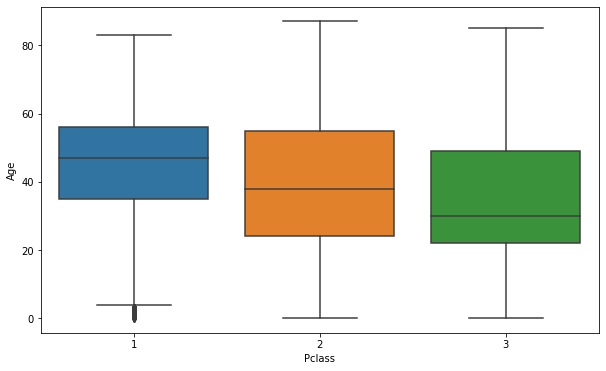

In [238]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Pclass", y="Age", data=data)


In [239]:
data.groupby('Pclass')['Age'].mean()


Pclass
1    44.774464
2    38.631237
3    33.407362
Name: Age, dtype: float64

Средний возраст по классам - 44.78, 38.63, 33.41 соответственно.

Так же воспрос с Ticket их вроде и не много но если посмотреть на распределение:

In [240]:
data['Ticket'].value_counts()

A/5             602
C.A.            177
SC/PARIS        145
SOTON/O.Q.       80
SC               57
               ... 
421812            1
PC 420601         1
PC 26800          1
STON/O 23755      1
458074            1
Name: Ticket, Length: 75331, dtype: int64

Явной закономерности в их содержании найти трудно, поэтому мы просто не будем пока использовать данный параметр.
И так обновим наши данные с учетом выше указанных выводов и предположений.

In [241]:
data_titanic = data.copy()

In [242]:
# убираем параметры 'Cabin' и 'Ticket'
data_titanic = data_titanic.drop(columns=['Cabin', 'Ticket'])

In [243]:
# Заменяем на 'S' все Nan в 'Embarked'
data_titanic['Embarked'] = data_titanic['Embarked'].fillna('S')

In [244]:
# Заменяем 'Age' на средний по 'Pclass'
data_titanic['Age'] = data_titanic.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))
# data_titanic['Survived'].value_counts()

In [245]:
# Заменяем 'Fare' на средний по 'Pclass'
data_titanic['Fare'] = data_titanic.groupby(
    'Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))


Проверим что все чисто

In [246]:
data_titanic.apply(lambda x: pd.isna(x)).sum()*100/data_titanic.shape[0]

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
dtype: float64

Все нормально можно продолжать. 

### Data exploration

Построим несколько простых графиков.

Text(0.5, 1.0, 'Распределение пассажиров\n по стоимости билетов')

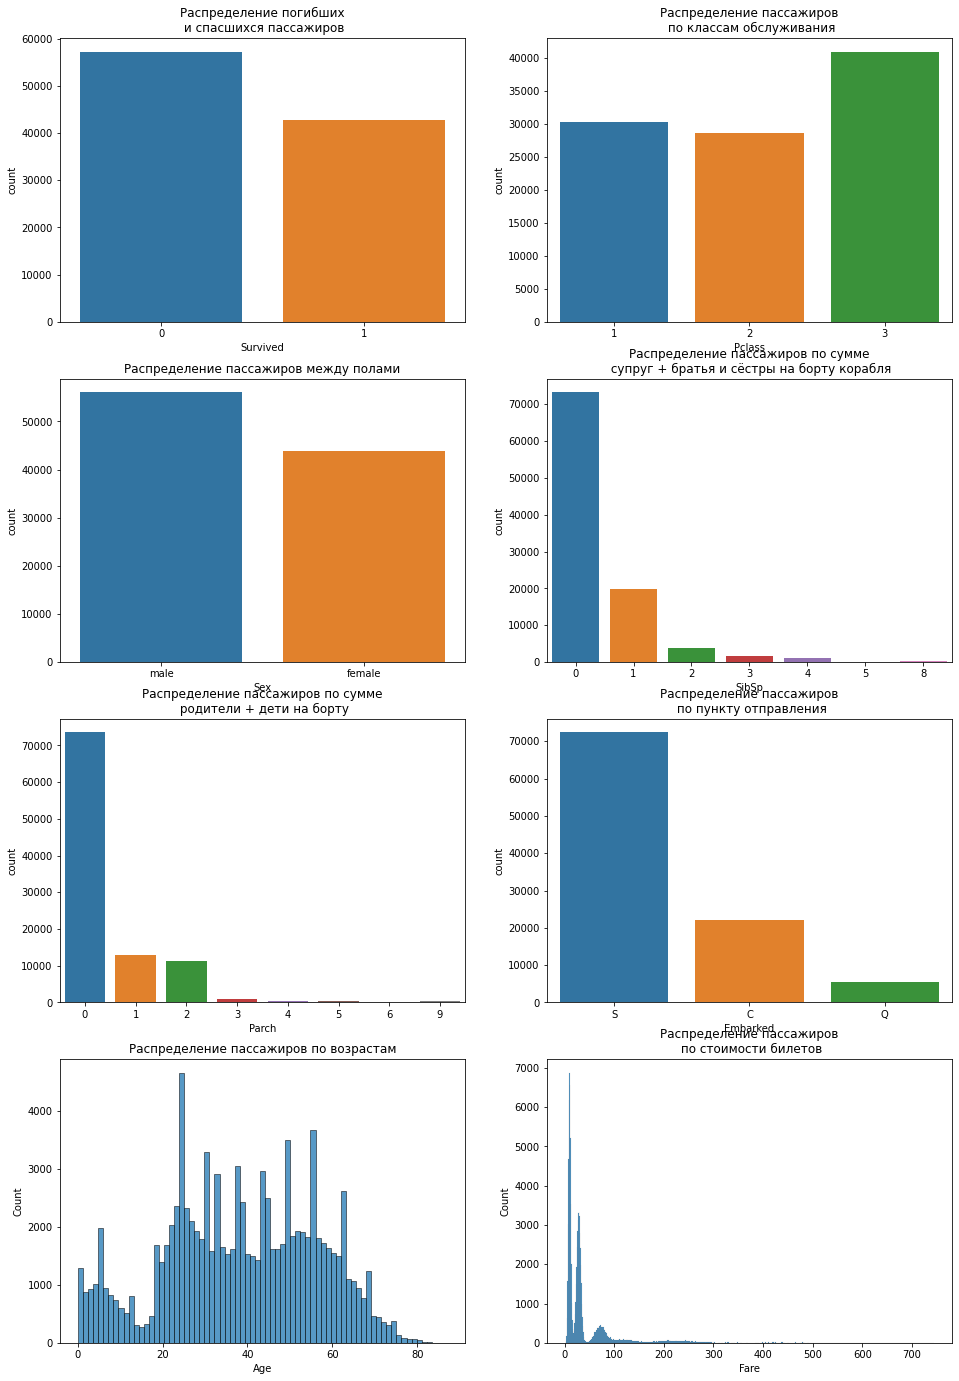

In [247]:
fig, ax = plt.subplots(4, 2, figsize=(16, 24))
sns.countplot(x=data_titanic['Survived'], ax=ax[0, 0])
sns.countplot(x=data_titanic['Pclass'],ax=ax[0, 1])
sns.countplot(x=data_titanic['Sex'], ax=ax[1, 0])
sns.countplot(x=data_titanic['SibSp'], ax=ax[1, 1])
sns.countplot(x=data_titanic['Parch'], ax=ax[2,0])
sns.countplot(x=data_titanic['Embarked'], ax=ax[2, 1])
sns.histplot(x=data_titanic['Age'], ax=ax[3, 0])
sns.histplot(x=data_titanic['Fare'], ax=ax[3, 1])
ax[0, 0].set_title('Распределение погибших\n и спасшихся пассажиров')
ax[0, 1].set_title('Распределение пассажиров\n по классам обслуживания')
ax[1, 0].set_title('Распределение пассажиров между полами')
ax[1, 1].set_title('Распределение пассажиров по сумме\n супруг + братья и сёстры на борту корабля')
ax[2, 0].set_title('Распределение пассажиров по сумме\n родители + дети на борту')
ax[2, 1].set_title('Распределение пассажиров\n по пункту отправления')
ax[3, 0].set_title('Распределение пассажиров по возрастам')
ax[3, 1].set_title('Распределение пассажиров\n по стоимости билетов')
# display(fig)


Предварительные выводы:

- больше пассажиров погибло чем спаслось
- подавляющее большинство пассажиров располагалось в третьем классе
- мужчин было больше чем женщин

Оценим взаимосвязи между каждой переменной и целевой переменной(выжил/не выжил)

Text(0.5, 1.0, 'Распределение погибших по сумме\n родители + дети на борту')

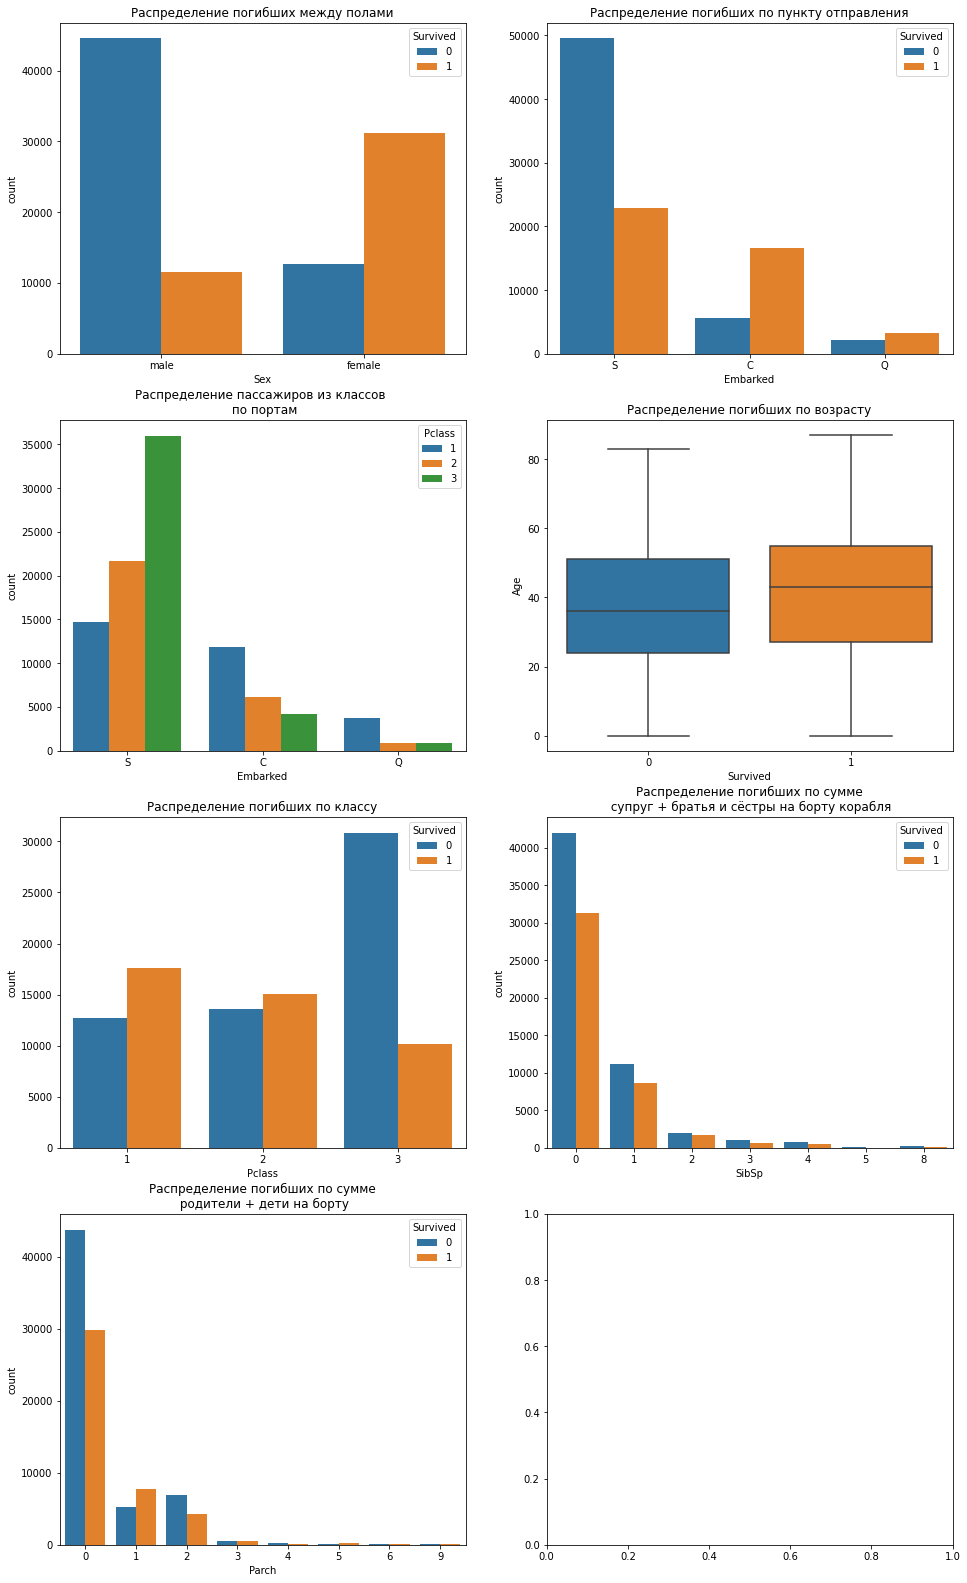

In [248]:
fig1, ax1 = plt.subplots(4, 2, figsize=(16, 28))
sns.countplot(x='Sex', data=data_titanic, hue='Survived', ax=ax1[0, 0])
sns.countplot(x='Embarked', data=data_titanic, hue='Survived', ax=ax1[0, 1])
sns.countplot(x='Embarked', data=data_titanic, hue='Pclass', ax=ax1[1, 0])
sns.boxplot(x='Survived', y='Age', data=data_titanic, ax=ax1[1, 1])
sns.countplot(x='Pclass', data=data_titanic, hue='Survived', ax=ax1[2, 0])
sns.countplot(x='SibSp', data=data_titanic, hue='Survived', ax=ax1[2, 1])
sns.countplot(x='Parch', data=data_titanic, hue='Survived',  ax=ax1[3, 0])
# sns.histplot(x=data_titanic['Fare'], ax=ax1[3, 1])
ax1[0, 0].set_title('Распределение погибших между полами')
ax1[0, 1].set_title('Распределение погибших по пункту отправления')
ax1[1, 0].set_title('Распределение пассажиров из классов \n по портам')
ax1[1, 1].set_title('Распределение погибших по возрасту')
ax1[2, 0].set_title('Распределение погибших по классу')
ax1[2, 1].set_title(
    'Распределение погибших по сумме\n супруг + братья и сёстры на борту корабля')
ax1[3, 0].set_title(
    'Распределение погибших по сумме\n родители + дети на борту')
# ax[3, 1].set_title('Распределение пассажиров\n по стоимости билетов')

Предварительные выводы

- У женщин выживаемость больше чем у мужчин, так как их спасали в первую очередь.
- Чем выше класс каюты пассажира — тем больше шансы выжить.
- Наличие родственников дает немного больше шансов выжить.
- Путешествующие из пункта 'S' имеют меньше шансов выжить, так как их большинство купило билеты в 3 класс.


Оценим взаимосвязь между переменными, предварительно отбросив Name и PassengerId.

<AxesSubplot:>

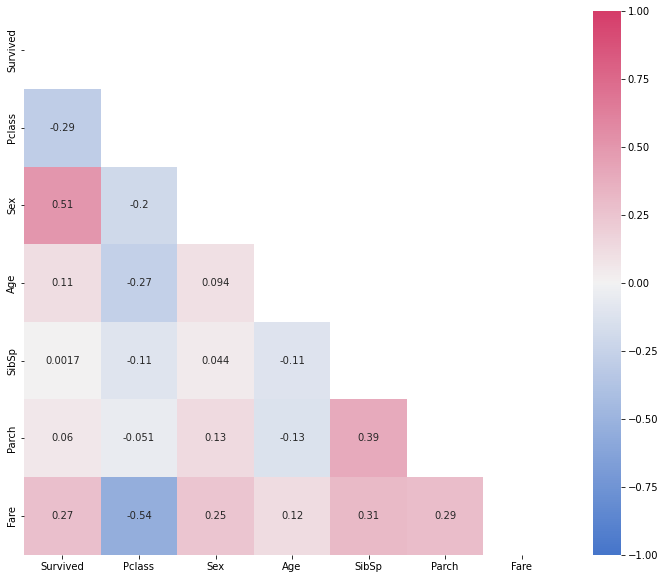

In [250]:
data_titanic_corr = data_titanic.copy().drop(columns=['Name', 'PassengerId'])
data_titanic_corr['Sex'] = data_titanic_corr['Sex'].map({'male': 0, 'female': 1})

plt.figure(figsize=(12, 10))
corr = data_titanic_corr.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, mask=mask, cmap=cmap)


# Summary

- больше пассажиров погибло чем спаслось
- подавляющее большинство пассажиров располагалось в третьем классе
- мужчин было больше чем женщин
- у женщин выживаемость больше чем у мужчин, так как их спасали в первую очередь.
- чем выше класс каюты пассажира — тем больше шансы выжить.
- наличие родственников дает немного больше шансов выжить.
- путешествующие из пункта 'S' имеют меньше шансов выжить, так как их большинство купило билеты в 3 класс.


Основная группа выживших — женщины первого и второго класса всех возрастов. 
Оценку выживаемости среди мужчин взависимости от разных параметров я не проводил. 